In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightfm import LightFM
from io import BytesIO
from PIL import Image
from math import ceil
from textwrap import wrap
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix, csr_matrix

In [ ]:
!mkdir ./data
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Book-Ratings.csv -O ./data/BX-Book-Ratings.csv
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Books.csv -O ./data/BX-Books.csv
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Users.csv -O ./data/BX-Users.csv

mkdir: cannot create directory ‘./data’: File exists
--2021-06-03 13:52:57--  https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Book-Ratings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30682276 (29M) [text/plain]
Saving to: ‘./data/BX-Book-Ratings.csv’

./data/BX-Book-Rati 100%[===================>]  29.26M   162MB/s    in 0.2s    

2021-06-03 13:52:57 (162 MB/s) - ‘./data/BX-Book-Ratings.csv’ saved [30682276/30682276]

--2021-06-03 13:52:57--  https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Books.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.gith

In [ ]:
books = pd.read_csv('./data/BX-Books.csv')
users = pd.read_csv('./data/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')
interactions = pd.read_csv('./data/BX-Book-Ratings.csv', sep=';', encoding = 'ISO-8859-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
interactions = interactions[interactions["Book-Rating"] != 0]

books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [ ]:
le = preprocessing.LabelEncoder()

interactions["product_id"] = le.fit_transform(interactions["ISBN"])
id_to_isbn = {id: isbn for (id, isbn) in enumerate(le.classes_)}

interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [ ]:
def show_books(id_list):
  pd.set_option('display.max_colwidth', None)

  n_rows = ceil(len(id_list) / 5)
  isbn_list = map(id_to_isbn.get, id_list)

  fig = plt.figure(figsize=(16, n_rows * 5))
  for i, book in enumerate(isbn_list):
    plt.subplot(n_rows, 5, i+1)
    plt.title('\n'.join(wrap(books[books['ISBN'] == book]['Book-Title'].to_string(index=False), 25)), fontsize=11)

    r = requests.get(books[books['ISBN'] == book]['Image-URL-L'].to_string(index=False))
    im = Image.open(BytesIO(r.content))

    plt.imshow(im)
    plt.axis('off')
  plt.show()

# Персональный топ

In [ ]:
age = 20
location = 'moscow, n/a, russia'

selected_by_age = users[abs(1 - users['Age'] / age) < .1]['User-ID']
selected_by_country = users[[location.split(sep=', ')[-1] in users['Location'][i] for i in range(len(users))]]['User-ID']

In [ ]:
selected_interactions = interactions[interactions['User-ID'].isin(set(selected_by_country) | set(selected_by_age))]

In [ ]:
top_books = selected_interactions['product_id'].value_counts()[:20].index
selected_interactions = selected_interactions[selected_interactions['product_id'].isin(top_books)]

In [ ]:
top_books = selected_interactions.groupby('product_id')['Book-Rating'].mean().sort_values(ascending=False).index[:10]

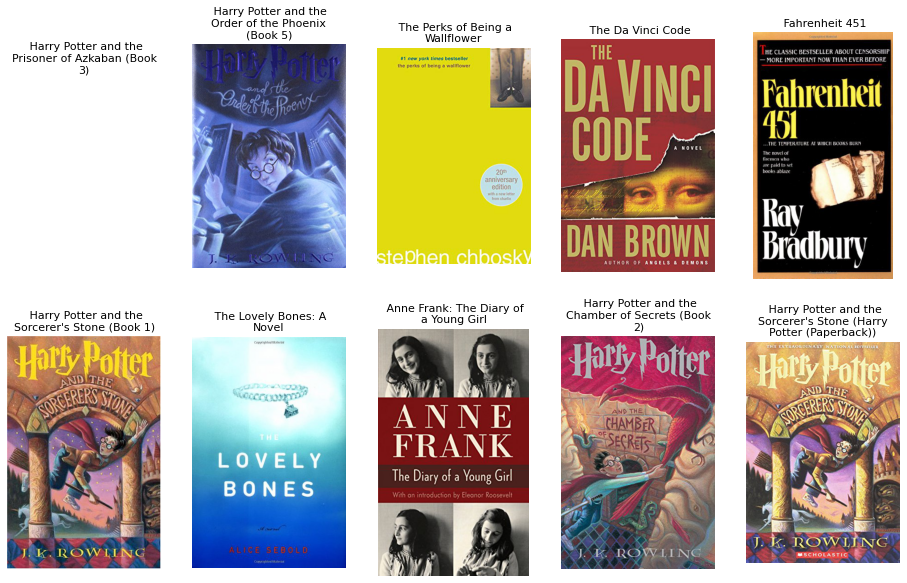

In [ ]:
show_books(top_books)

# Совстречаемость

In [ ]:
class Coocurrency():
  def __init__(self, Int):
    self.interactions = Int
    self.rates = coo_matrix((Int["Book-Rating"], (Int["vid"], Int["product_id"])), 
                            shape=(len(set(Int["vid"])), len(set(Int["product_id"])))).toarray()
  

  def count(self):
    Int = self.interactions[['vid', 'product_id', 'Book-Rating']].drop_duplicates()
    books_by_user = Int.groupby('vid')['product_id'].apply(list).to_frame()
    books_num = np.array([len(i) for i in books_by_user['product_id']])
    books_by_user['books_num'] = books_num
    books_by_user = books_by_user[books_by_user['books_num'] > 1]

    cooc = {}
    for idx, i in zip(books_by_user.index, books_by_user['product_id']):
      for j in range(len(i)):
        for k in range(len(i)):
          if j != k:
            score = (self.rates[idx, i[j]] + self.rates[idx, i[k]]) / 2
            try:
              cooc[str(i[j]) + "_" + str(i[k])] += score
            except:
              cooc[str(i[j]) + "_" + str(i[k])] = score
    
    cooc_list = []
    for i, j in cooc.items():
        if j > 5:
            cooc_list.append(i.split("_") + [j])
    self.cooc_rec = pd.DataFrame(cooc_list, columns=['book1', 'book2', 'measure'])
  
  
  def get_rec(self, i, show=False):
    recs = self.cooc_rec[self.cooc_rec['book1'] == str(i)]\
                        .sort_values("measure", ascending=False)\
                        .head(10)
    print('Для книги')
    show_books([i])
    print(u"Такие рекомендации")
    show_books(recs['book2'].values.astype(int))

In [ ]:
c = Coocurrency(interactions)
c.count()

Для книги


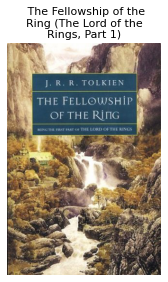

Такие рекомендации


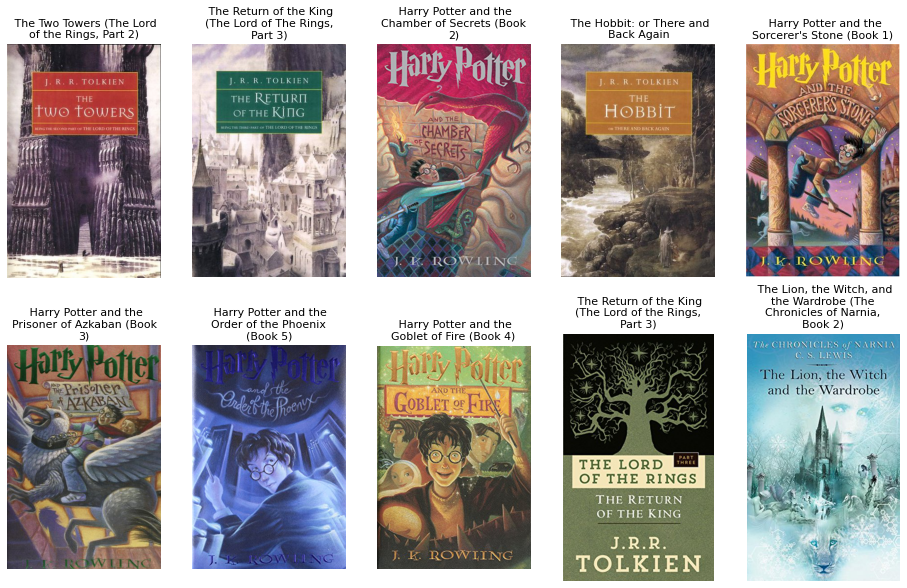

In [ ]:
c.get_rec(7164)

# Коллаборативная фильтрация

In [ ]:
class Colloborative():
  def __init__(self, Int):
    self.interactions = Int
    self.rates = coo_matrix((Int["Book-Rating"], (Int["vid"], Int["product_id"])), 
                            shape=(len(set(Int["vid"])), len(set(Int["product_id"]))))
  
  def user_based(self, idx):
    user_rates = self.rates.getrow(idx).toarray()[0]
    rated_books = np.where(user_rates != 0)[0]
    sim = cosine_similarity([user_rates], self.rates).reshape(-1, 1)

    average_for_users = self.rates.sum(axis=1).A1 / (self.rates != 0).sum(axis=1).A1
    user_average_rate = average_for_users[idx]

    rates = np.multiply(self.rates - np.diag(average_for_users) @ self.rates.astype(bool), sim).sum(axis=0) / sim.sum(axis=0)
    rates = (rates + user_average_rate).A1 * (1 - user_rates.astype(bool))

    self.get_rec(rated_books, np.arange(self.rates.shape[1])[np.argsort(rates)[::-1][:10]])

  def item_based(self, idx):
    item_rates = self.rates.getcol(idx).toarray().ravel()
    sim = cosine_similarity([item_rates], self.rates.T).reshape(-1, 1)

    average_for_items = self.rates.sum(axis=0).A1 / (self.rates != 0).sum(axis=0).A1
    item_average_rate = average_for_items[idx]

    rates = np.multiply((self.rates - self.rates.astype(bool) @ np.diag(average_for_items)).T, sim).sum(axis=0) / sim.sum(axis=0)
    rates = (rates + item_average_rate).A1 * (1 - item_rates.astype(bool))
    top_users = np.arange(self.rates.shape[0])[np.argsort(rates)[::-1][:50]]

    self.get_rec([idx], np.argsort(-self.rates.toarray()[top_users].mean(axis=0))[:10])

  def get_rec(self, watched, recs):
    print('Для таких книг')
    show_books([i for i in watched])
    print('Такие рекомендации')
    show_books([i for i in recs])

In [ ]:
clb = Colloborative(interactions)

Для таких книг


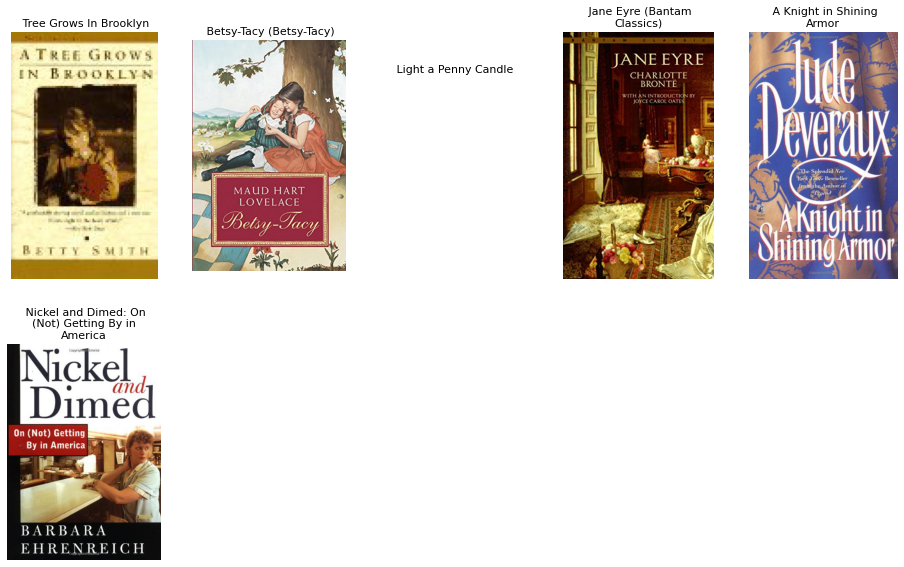

Такие рекомендации


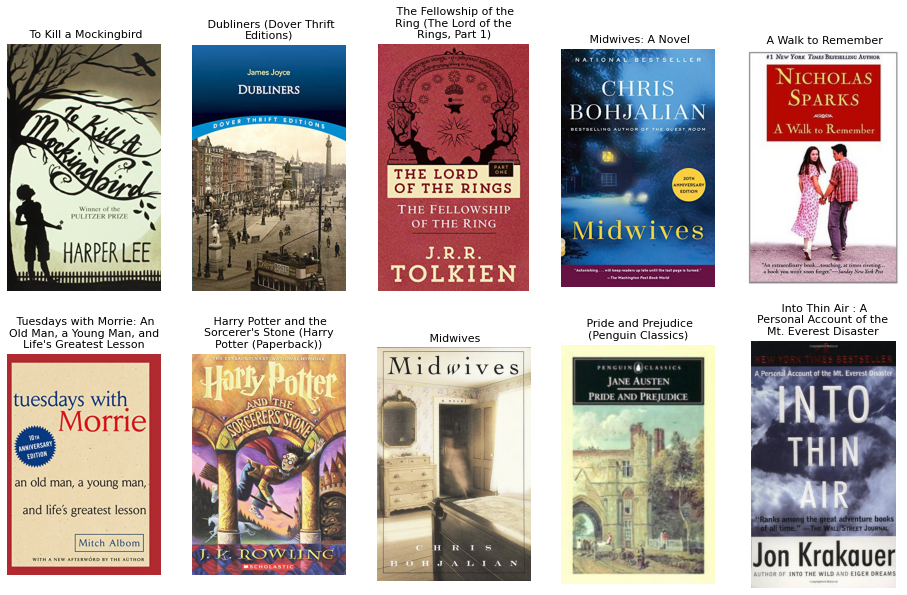

In [ ]:
clb.user_based(1234)

Для таких книг


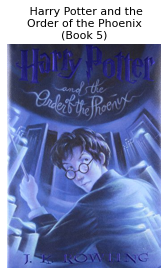

Такие рекомендации


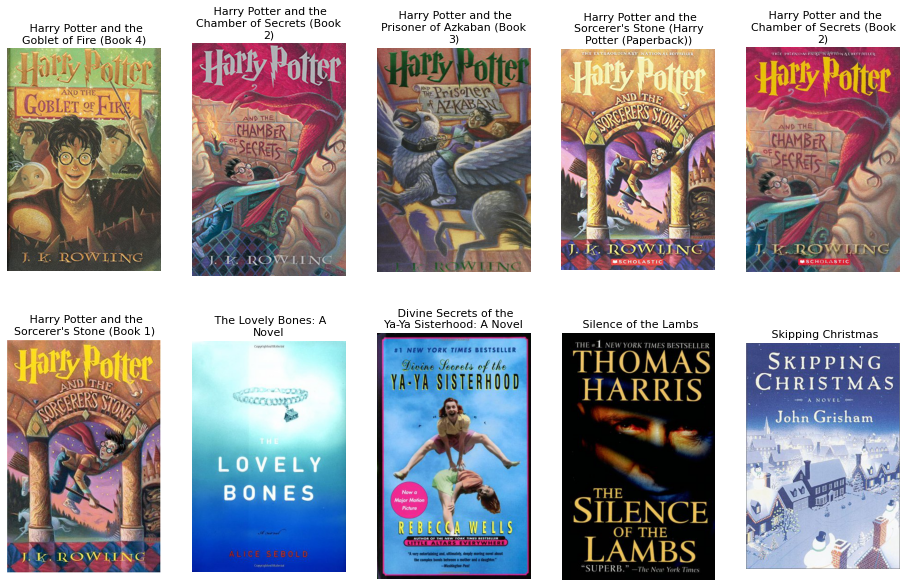

In [ ]:
clb.item_based(4233)

# Матричная Факторизация

In [ ]:
class MatrixFactorization(): 
  def __init__(self, Int, no_components):
    self.n = no_components
    self.rates = coo_matrix((Int["Book-Rating"], (Int["vid"], Int["product_id"])),
                            shape=(len(set(Int["vid"])), len(set(Int["product_id"]))))
    
  def LightFM(self):
    self.model = LightFM(loss='warp', no_components=self.n, learning_rate=0.05, learning_schedule="adadelta")
    self.model.fit(self.rates, epochs=10, num_threads=40, verbose=True)
    self.user_feature_bias, self.users_embs = self.model.get_user_representations()
    self.item_feature_bias, self.items_embs = self.model.get_item_representations()

  def get_rec_I2I(self, i):
    metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
    
    print('Для книги')
    show_books([i])
    print('Такие рекомендации')
    show_books(np.argsort(-metrics)[0][1:11])
  
  def get_rec_U2I(self, i):
    self.rated_books = self.rates.toarray()[i].astype(bool)
    metrics = cosine_similarity([self.users_embs[i]], self.users_embs)

    print('Для книг')
    show_books(*np.where(self.rates.toarray()[i] != 0))
    print('Такие рекомендации')
    show_books(np.argsort(-self.rates.multiply(~self.rated_books).toarray()[np.argsort(-metrics)[0][1:51]].mean(axis=0))[:10])

In [ ]:
mf = MatrixFactorization(interactions, 150)
mf.LightFM()

Epoch: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Для книги


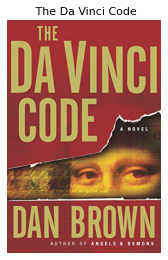

Такие рекомендации


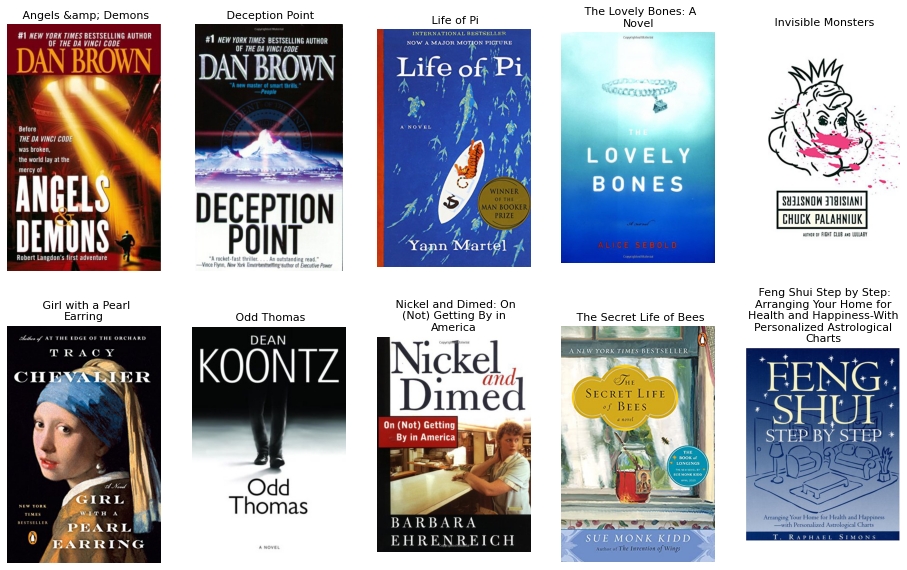

In [ ]:
mf.get_rec_I2I(3461)

Для книг


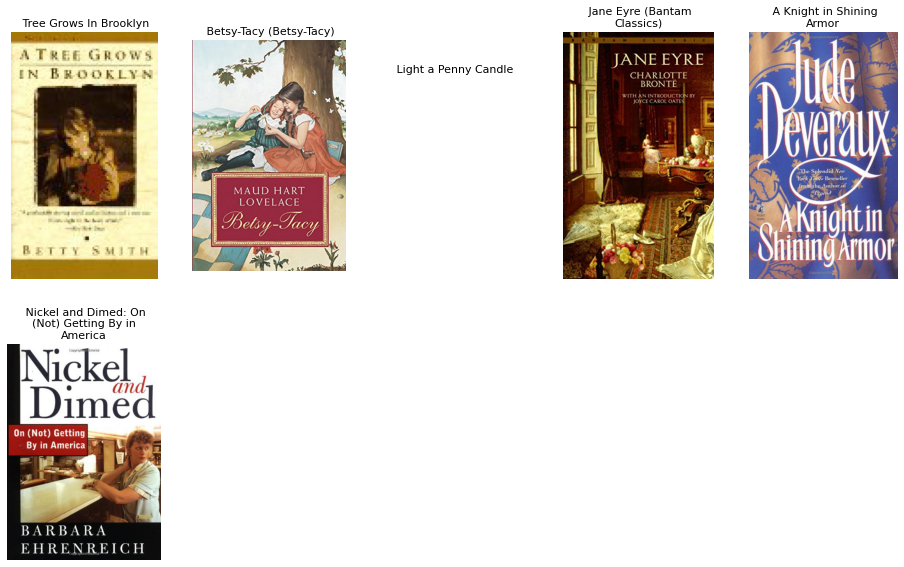

Такие рекомендации


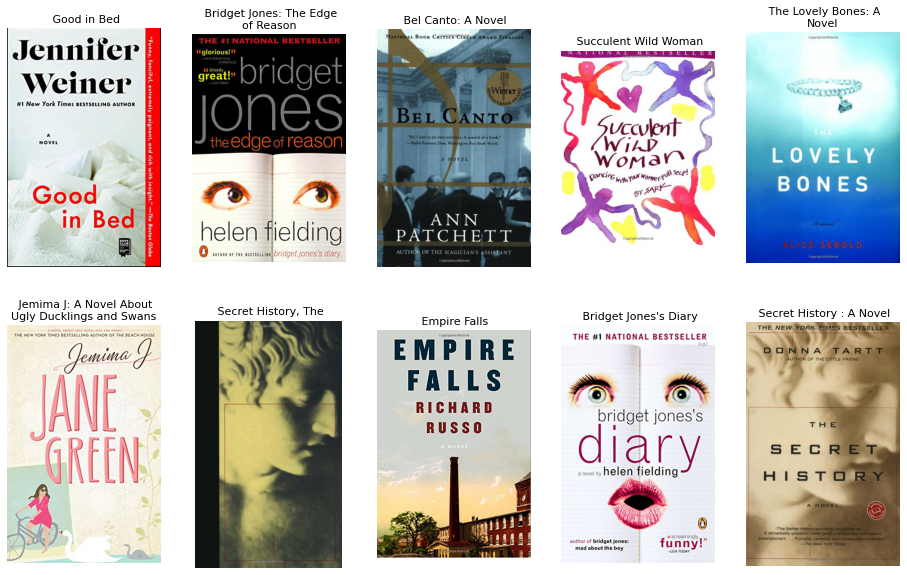

In [ ]:
mf.get_rec_U2I(1234)